In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
is_ripple, spikes, position, speed, env, time, position2D = load_data()
spikes = (spikes > 0).astype(int)
spike_times = [time[spike.astype(bool)] for spike in spikes.T]


sampling_frequency = 500
time_range = (time[0], time[-1] + (1 / sampling_frequency))

n_time_bins = (
    int((time_range[-1] - time_range[0]) * sampling_frequency) + 1
)
t = time_range[0] + np.arange(n_time_bins) / sampling_frequency

np.allclose(t, time)

17-May-24 10:53:34 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


True

In [3]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "block_size": 10_000,
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

17-May-24 10:54:21 Fitting initial conditions...
17-May-24 10:54:21 Fitting discrete state transition
17-May-24 10:54:21 Fitting continuous state transition...
17-May-24 10:54:22 Fitting place fields...
17-May-24 10:54:24 Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
17-May-24 10:54:24 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
17-May-24 10:54:24 Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
17-May-24 10:54:24 Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

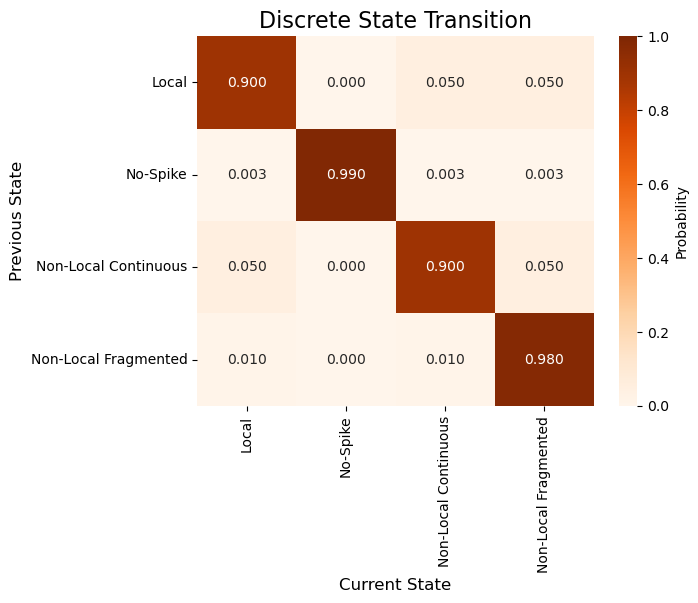

In [4]:
detector.plot_discrete_state_transition()

In [6]:
results = detector.predict(spike_times, time, position2D, time)
results

17-May-24 10:55:21 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

No Spike Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

17-May-24 11:23:31 Computing posterior...
17-May-24 11:24:37 Finished computing posterior...


<xarray.Dataset>
Dimensions:                      (time: 452325, state_bins: 404, states: 4,
                                  state_ind: 404)
Coordinates:
  * time                         (time) float64 2.239e+04 ... 2.329e+04
  * state_bins                   (state_bins) object MultiIndex
  * state                        (state_bins) object 'Local' ... 'Non-Local F...
  * position                     (state_bins) float64 nan nan ... 420.7 422.7
  * state_ind                    (state_ind) int64 0 1 2 2 2 2 2 ... 3 3 3 3 3 3
  * states                       (states) <U20 'Local' ... 'Non-Local Fragmen...
    environments                 (states) <U1 '' '' '' ''
    encoding_groups              (states) int64 0 0 0 0
Data variables:
    acausal_posterior            (time, state_bins) float32 1.0 ... 0.004688
    acausal_state_probabilities  (time, states) float64 1.0 1.284e-16 ... 0.4112
Attributes:
    marginal_log_likelihoods:  -1923512.8

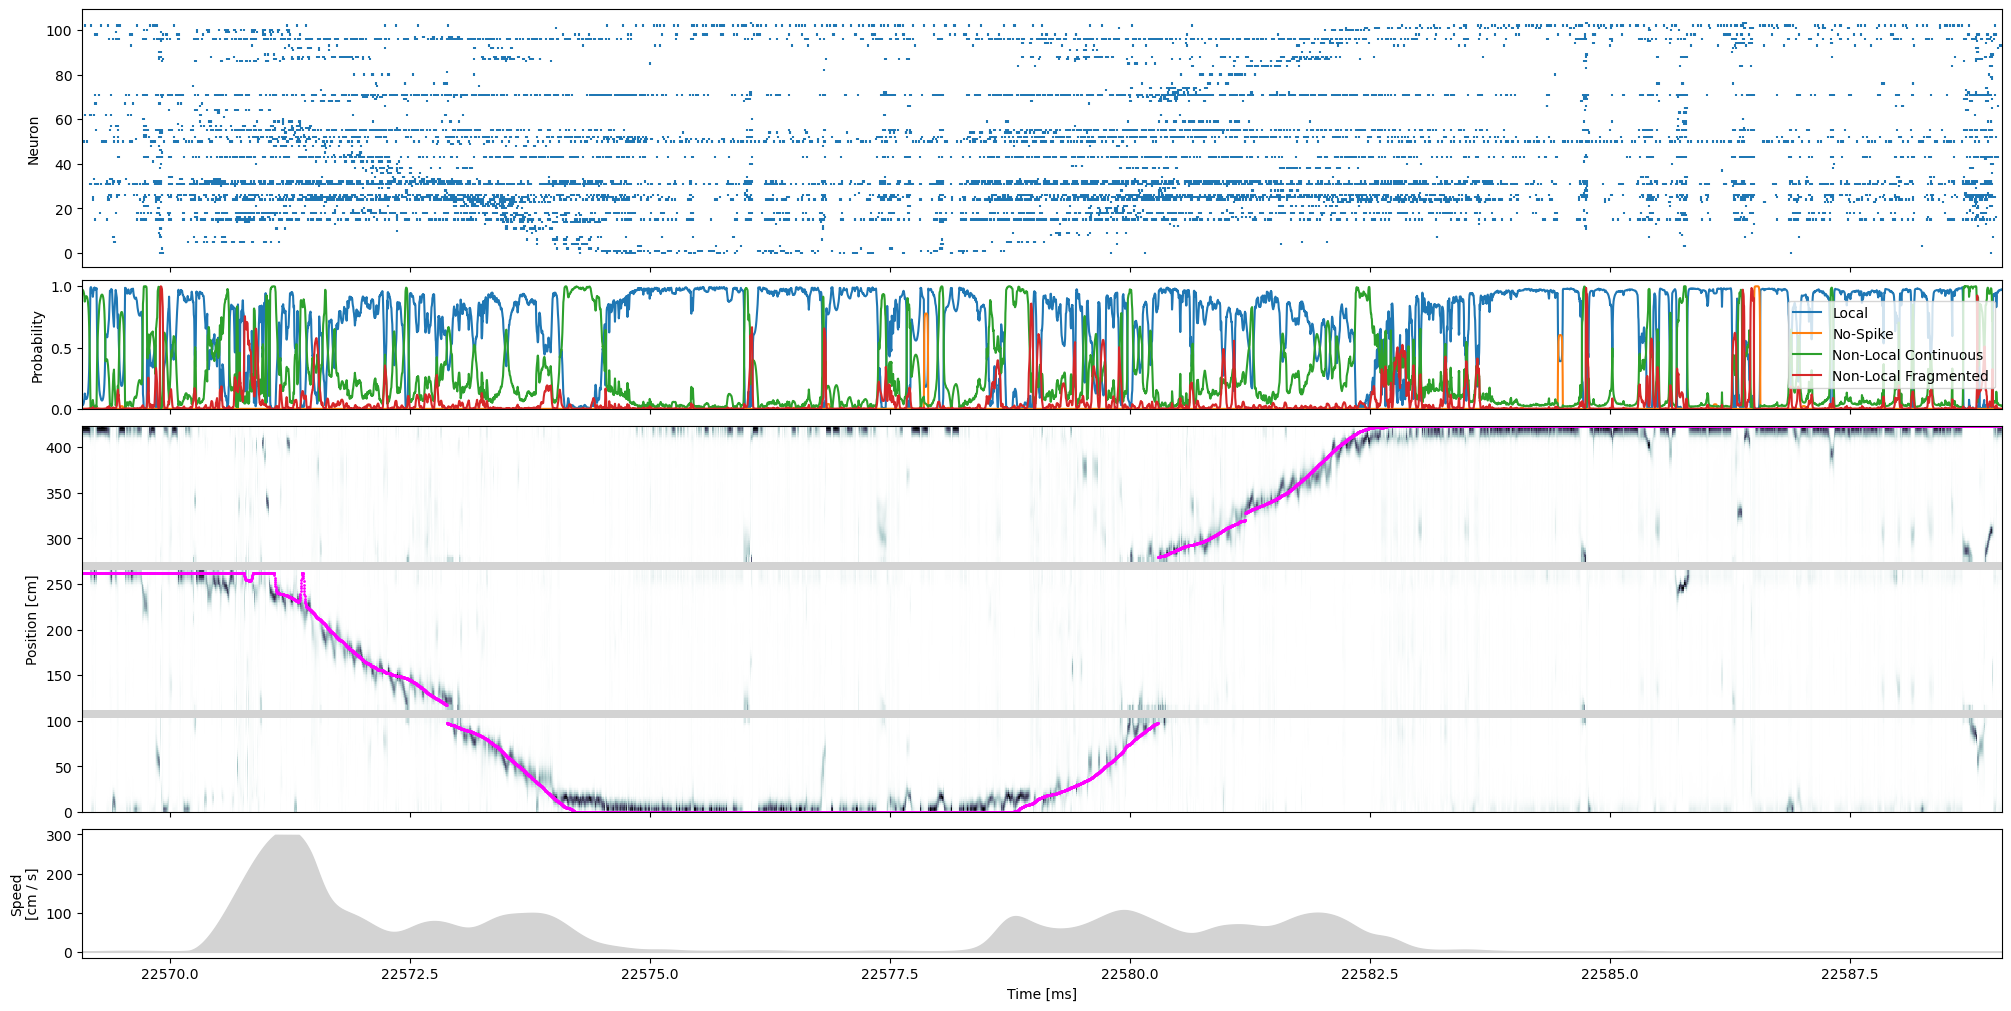

In [9]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spike_times,
    speed,
    detector,
    results,
    time_slice=slice(time[90_000], time[100_000]),
    figsize=(20, 10),
)

In [ ]:
from non_local_detector import ContFragSortedSpikesClassifier

classifier = ContFragSortedSpikesClassifier(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "block_size": 10_000,
    },
).fit(time, position2D, spike_times, is_training=~is_ripple)

classifier_results = classifier.predict(spike_times, time_range)

In [ ]:
from non_local_detector.likelihoods.sorted_spikes_kde import KDEModel
import matplotlib.pyplot as plt

neuron_ind = 3
marginal = KDEModel(std=6.0, block_size=10_000).fit(position[spikes[:, neuron_ind].astype(bool)]).predict(env.place_bin_centers_)
mean_rate = np.mean(spikes[:, neuron_ind])
occupancy = KDEModel(std=6.0, block_size=10_000).fit(position).predict(env.place_bin_centers_)
original_place_field = mean_rate * marginal / occupancy

plt.plot(env.place_bin_centers_, classifier.encoding_model_[('', 0)]['place_fields'][neuron_ind])
plt.plot(env.place_bin_centers_, mean_rate * marginal / occupancy)

plt.scatter(position[spikes[:, neuron_ind].astype(bool)], np.zeros_like(position[spikes[:, neuron_ind].astype(bool)]), marker="+")

In [ ]:
import jax.numpy as jnp
from non_local_detector.likelihoods.sorted_spikes_kde import get_position_at_time, EPS

neuron_spike_times = spike_times[neuron_ind]
position_time = time
sampling_frequency = 500
n_time_bins = int((position_time[-1] - position_time[0]) * sampling_frequency)

is_track_interior = env.is_track_interior_.ravel(order="F")
interior_place_bin_centers = env.place_bin_centers_[is_track_interior]

occupancy_model = KDEModel(std=6.0, block_size=10_000).fit(position)
occupancy = occupancy_model.predict(interior_place_bin_centers)

neuron_spike_times = neuron_spike_times[
    jnp.logical_and(
        neuron_spike_times >= position_time[0],
        neuron_spike_times <= position_time[-1],
    )
]
mean_rate = len(neuron_spike_times) / n_time_bins
neuron_marginal_model = KDEModel(std=6.0, block_size=10_000).fit(
    get_position_at_time(
        position_time, position[:, None], neuron_spike_times, env
    )
)
marginal_density = neuron_marginal_model.predict(interior_place_bin_centers)
place_field = jnp.zeros((is_track_interior.shape[0],))
place_field = place_field.at[is_track_interior].set(
        jnp.clip(
            mean_rate
            * jnp.where(occupancy > 0.0, marginal_density / occupancy, EPS),
            a_min=EPS,
            a_max=None,
        )
    )

plt.plot(env.place_bin_centers_, place_field)
plt.plot(env.place_bin_centers_, original_place_field)

position_at_spike = get_position_at_time(
        position_time, position[:, None], neuron_spike_times, env
)
plt.scatter(position_at_spike, np.zeros_like(position_at_spike), marker="+")

In [ ]:


fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)
classifier_results.isel(time=slice(90_000, 100_000)).acausal_posterior.unstack("state_bins").sum("position").plot(
    x="time", hue="state", ax=axes[0]
)
axes[0].set_ylim((0, 1.1))
classifier_results.isel(time=slice(90_000, 100_000)).acausal_posterior.unstack("state_bins").sum("state").plot(
    x="time", y="position", ax=axes[1]
)

In [ ]:
spike_count_per_time_bin = np.stack(
    [
        np.bincount(
            np.digitize(neuron_spike_times, classifier_results.time[1:-1]),
            minlength=classifier_results.time.shape[0],
        )
        for neuron_spike_times in spike_times
    ],
    axis=1,
)

In [ ]:
spike_count_per_time_bin.sum(axis=0)

In [ ]:
spikes.sum(axis=0)

In [ ]:
np.nonzero(np.abs(spike_count_per_time_bin - spikes) > 0)

In [ ]:
classifier.plot_place_fields()

In [ ]:
results = detector.estimate_parameters(spikes, position, time=time)

In [ ]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    time,
    position,
    spikes,
    speed,
    detector,
    results,
    time_slice=slice(90_000, 100_000),
    figsize=(20, 10),
)

In [ ]:
detector.plot_discrete_state_transition()